In [1]:
import os
import random
import pandas as pd
import datetime
import numpy as np
from sklearn.preprocessing import LabelEncoder
from etl.data_processor import FeatureProcessor, VERB_MAP, OBSERVABLE
import tensorflow as tf
import matplotlib.pyplot as plt
tf.keras.layers.Conv1D

/Users/xuqiushi/.venvs/naep2019-QtP7hbym/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xuqiushi/.venvs/naep2019-QtP7hbym/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xuqiushi/.venvs/naep2019-QtP7hbym/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xuqiushi/.venvs/naep2

tensorflow.python.keras.layers.convolutional.Conv1D

In [4]:
data_a_train = pd.read_csv(os.path.join("../data/raw/", "data_a_train.csv"))
data_a_train[OBSERVABLE] = data_a_train[OBSERVABLE].apply(
    lambda x: VERB_MAP[x] if x in VERB_MAP else x
)
data_a_hidden = pd.concat(
    [
        pd.read_csv(os.path.join("../data/raw/", "data_a_hidden_10.csv")),
        pd.read_csv(os.path.join("../data/raw/", "data_a_hidden_20.csv")),
        pd.read_csv(os.path.join("../data/raw/", "data_a_hidden_30.csv")),
    ],
    axis=0,
    sort=False
)
data_a_hidden[OBSERVABLE] = data_a_hidden[OBSERVABLE].apply(
    lambda x: VERB_MAP[x] if x in VERB_MAP else x
)
verb_ln = LabelEncoder()
verb_ln.fit(data_a_train["Observable"].tolist() + data_a_hidden["Observable"].tolist())
hidden_index, hidden = FeatureProcessor().get_multi_dim_verb(data_a_hidden)
train_index, train = FeatureProcessor().get_multi_dim_verb(data_a_train)
verb_ln.fit(list(hidden[:, :, 3].ravel())+list(train[:, :, 3].ravel()))
hidden[:, :, 3] = verb_ln.transform(hidden[:, :, 3].ravel()).reshape(hidden[:, :, 3].shape)
train[:, :, 3] = verb_ln.transform(train[:, :, 3].ravel()).reshape(train[:, :, 3].shape)
label = pd.read_csv(os.path.join("../data/raw/", "data_train_label.csv")).set_index("STUDENTID")
label = label.reindex(train_index)
train = train.astype(np.int32)
hidden = hidden.astype(np.int32)

In [5]:
print(train.shape)
print(label.shape)
print(hidden.shape)
zip_combine = list(zip(label.values, train))
random.shuffle(zip_combine)
label_values, train = zip(*zip_combine)
train = np.array(train)
label_values = np.array(label_values).astype(int)
tmp_train = np.zeros(hidden.shape)
tmp_train[0: train.shape[0], 0: train.shape[1], 0: train.shape[2]] = train
train = tmp_train 
print(train.shape)
print(hidden.shape)
print(train[:, :, 0].shape)

(1232, 33, 4)
(1232, 1)
(1232, 54, 4)
(1232, 54, 4)
(1232, 54, 4)
(1232, 54)


In [19]:
verb_input = tf.keras.layers.Input(shape=(train.shape[1],))
verb_embedding = tf.keras.layers.Embedding(
    output_dim=10, 
    input_dim=len(verb_ln.classes_)+1, 
    input_length=train.shape[1],
)(verb_input)
input_ = tf.keras.layers.Input(shape=(train.shape[1], train.shape[2]-1))
merged_input = tf.keras.layers.concatenate(
    [input_, verb_embedding],
    axis=-1
)
conv1d_1 = tf.keras.layers.Conv1D(100, 10, activation='relu', input_shape=(train.shape[1], train.shape[2]))(merged_input)
conv1d_2 = tf.keras.layers.Conv1D(100, 10, activation='relu')(conv1d_1)
max_pool = tf.keras.layers.MaxPooling1D(3)(conv1d_2)
conv1d_3 = tf.keras.layers.Conv1D(100, 3, activation='relu')(max_pool)
conv1d_4 = tf.keras.layers.Conv1D(100, 3, activation='relu')(conv1d_3)
gloable_average = tf.keras.layers.GlobalAveragePooling1D()(conv1d_4)
dropout = tf.keras.layers.Dropout(0.5)(gloable_average)
output = tf.keras.layers.Dense(
    1, 
    activation='sigmoid'
    )(dropout)
model = tf.keras.Model(
    inputs=[input_, verb_input],
    outputs=output
)
optimizer = tf.keras.optimizers.Adam()
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['acc']
)
print(model.summary())
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 54, 3)]      0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 54, 10)       19430       input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 54, 13)       0           input_4[0][0]                    
                                                                 embedding_1[0][0]          

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_graph=True,
    write_grads=True,
    write_images=False,
    update_freq="epoch"
)

In [21]:
history = model.fit(
    [train[:, :, :3], train[:, :, 3]],  
    label_values,
    # batch_size=100,
    shuffle = True,
    epochs=30,
    validation_split=0.33,
    # callbacks=[tensorboard_callback],
)

Train on 825 samples, validate on 407 samples
Epoch 1/30
825/825 [==============================] - 1s 2ms/sample - loss: 56.7758 - acc: 0.5333 - val_loss: 7.5284 - val_acc: 0.4251
Epoch 2/30
825/825 [==============================] - 1s 853us/sample - loss: 6.4554 - acc: 0.5552 - val_loss: 0.8225 - val_acc: 0.6093
Epoch 3/30
825/825 [==============================] - 1s 805us/sample - loss: 1.2310 - acc: 0.5552 - val_loss: 0.6919 - val_acc: 0.5995
Epoch 4/30
825/825 [==============================] - 1s 940us/sample - loss: 0.7545 - acc: 0.5770 - val_loss: 0.7414 - val_acc: 0.6216
Epoch 5/30
825/825 [==============================] - 1s 1ms/sample - loss: 0.7027 - acc: 0.6109 - val_loss: 0.7266 - val_acc: 0.6290
Epoch 6/30
825/825 [==============================] - 1s 791us/sample - loss: 0.6860 - acc: 0.6097 - val_loss: 0.7028 - val_acc: 0.6634
Epoch 7/30
825/825 [==============================] - 1s 825us/sample - loss: 0.6354 - acc: 0.6424 - val_loss: 0.6884 - val_acc: 0.6757
Epoch

In [25]:
hidden_label = pd.read_csv(os.path.join("../data/raw/", "hidden_label.csv"))
hidden_result = model.predict([hidden[:, :, :3], hidden[:, :, 3]])
hidden_result_value = hidden_result.ravel()
print(hidden_result_value)
predict_result = pd.DataFrame(hidden_result_value, index=hidden_index).reindex(hidden_index)
print(predict_result)

[0.05926341 0.07090107 0.28299767 ... 0.35753423 0.00694072 0.0068754 ]
                   0
2333000106  0.059263
2333000190  0.070901
2333000289  0.282998
2333000386  0.044769
2333000637  0.007860
...              ...
2333383927  0.077089
2333384672  0.161163
2333384869  0.357534
2333385024  0.006941
2333385181  0.006875

[1232 rows x 1 columns]


In [26]:
print(hidden_result.ravel())
hidden_result_value = hidden_result.ravel()
predict_result = pd.DataFrame(hidden_result_value, index=hidden_index).reindex(hidden_index)
print(predict_result)
predict_result.to_csv(
    "result.csv",
    line_terminator=",",
    index=False,
    header=False
)

[0.05926341 0.07090107 0.28299767 ... 0.35753423 0.00694072 0.0068754 ]
                   0
2333000106  0.059263
2333000190  0.070901
2333000289  0.282998
2333000386  0.044769
2333000637  0.007860
...              ...
2333383927  0.077089
2333384672  0.161163
2333384869  0.357534
2333385024  0.006941
2333385181  0.006875

[1232 rows x 1 columns]


In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

[0.42506143, 0.6093366, 0.5995086, 0.6216216, 0.6289926, 0.66339064, 0.6756757, 0.64373463, 0.67076164, 0.66584766, 0.6486486, 0.6609337, 0.65356266, 0.63882065, 0.63882065, 0.63882065, 0.63144964, 0.64619166, 0.6167076, 0.6486486, 0.65847665, 0.63390666, 0.63144964, 0.64373463, 0.6560196, 0.63882065, 0.5970516, 0.5970516, 0.64619166, 0.63144964]


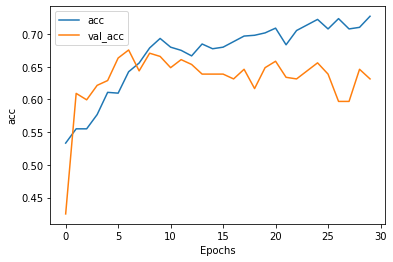

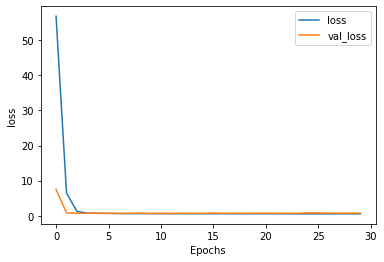

In [28]:
print(history.history['val_acc'])
plot_graphs(history, 'acc')

plot_graphs(history, 'loss')
